**Introduction**<br>
We used databases containing information on Pittsburgh's neighborhoods to determine which neighborhood is the best. We had decided on Hays as the best neighborhood in Pittsburgh. We mostly used the metrics that would normalize the amount of danger in a neighborhood (in terms of fires, crimes, and food safety). We came up with this metric as generally a big concern about a neighborhood is how safe it is for someone to live in. Many of the other metrics that can be used have a general trend upward with safety. Also, we had looked through the databases for information that would be strong in showing how good a neighborhood will be. After we got the databases, we realized that figuring out the safety of a neighborhood made a lot of sense and felt pretty intuitive. We initially had poison control instead of food safety, but the poison control database did not line up well with the other databases so we switched it out.

In [9]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point, Polygon
# We first import our libraries

**Fire Incident Database - Jason Wein**<br>
First, we do read in the files and do some data cleaning.

In [10]:
data = pd.read_csv("fire_incidents.csv")
gdf = geopandas.read_file("neighborhoods.geojson")
datageom = pd.read_csv("neigh_geom.csv")

In [11]:
data = data.dropna(subset=['incident_type', 'alarm_time'])
data['alarm_time'] = pd.to_datetime(data['alarm_time'])
data = data[~(data['alarm_time'] < '2020-01-01')]
data = data[data.neighborhood.isin(datageom.hood)]

Next, we calculate the fire density.

In [12]:
fires = data.groupby('neighborhood').size()
fires = fires.to_frame().reset_index()
fires.columns = ['hood', 'freq']
gdf = pd.merge(gdf, fires, on='hood')
gdf['fire_density']=gdf['freq']/gdf['acres']

datageom = pd.merge(datageom, fires, on='hood')
datageom['fire_density']=datageom['freq']/datageom['acres']

We can plot the fire density as follows.

<Axes: >

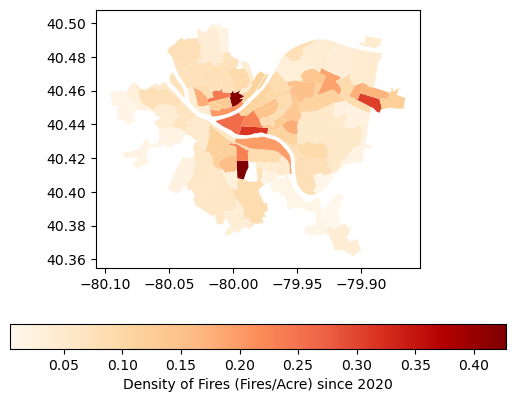

In [13]:
gdf.plot(column='fire_density', legend=True, cmap='OrRd', legend_kwds={"label": "Density of Fires (Fires/Acre) since 2020", "orientation": "horizontal"})

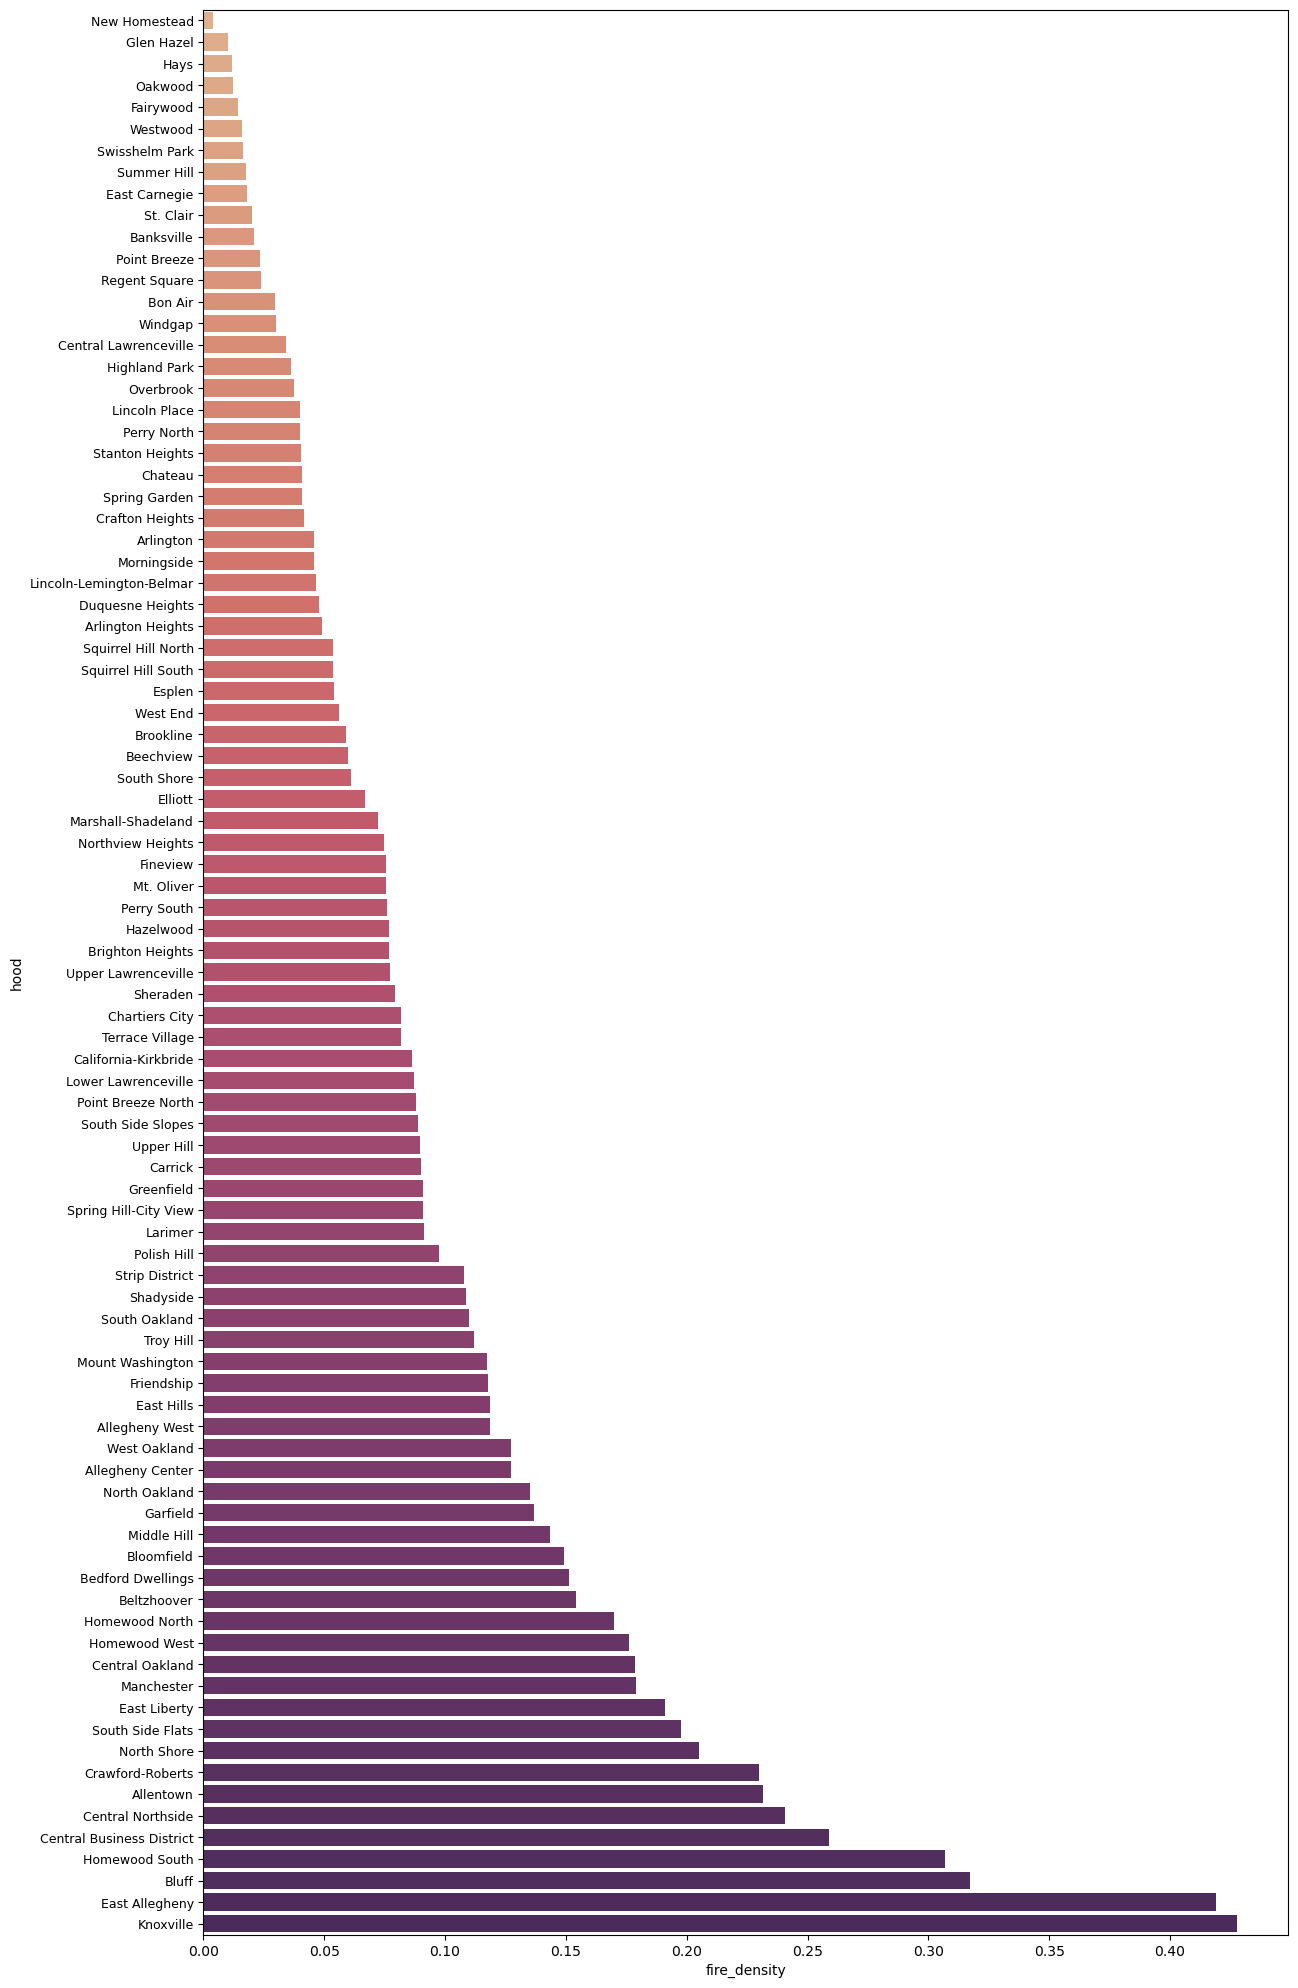

In [14]:
plt.figure(figsize=(14, 25))
datageom = datageom.sort_values('fire_density')
sns.barplot(data=datageom, y='hood', x='fire_density', palette='flare')
plt.yticks(fontsize=9)
plt.show()

**Food Safety Data - Hanzhang Bao**

In [15]:
df = pd.read_csv('All Food.csv')

In [17]:
df_clean = df.dropna(subset=['inspect_dt', 'facility_name', 'description', 'municipal', 'placard_desc'])
df_clean['inspect_dt'] = pd.to_datetime(df_clean['inspect_dt'], errors='coerce')

df_reduced = df_clean[['inspect_dt', 'facility_name', 'description', 'municipal', 'placard_desc']]
df_reduced['inspect_dt'] = df_reduced['inspect_dt'].dt.year

/scratch/slurm-13557/ipykernel_172951/1665346040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['inspect_dt'] = df_reduced['inspect_dt'].dt.year


In [18]:
df_violations = df_reduced[df_reduced['placard_desc'] != "Inspected & Permitted"]

violation_counts = df_violations.groupby('municipal')['facility_name'].nunique().reset_index(name='ViolationFacilityCount')
violation_counts = violation_counts.sort_values('ViolationFacilityCount', ascending=False)

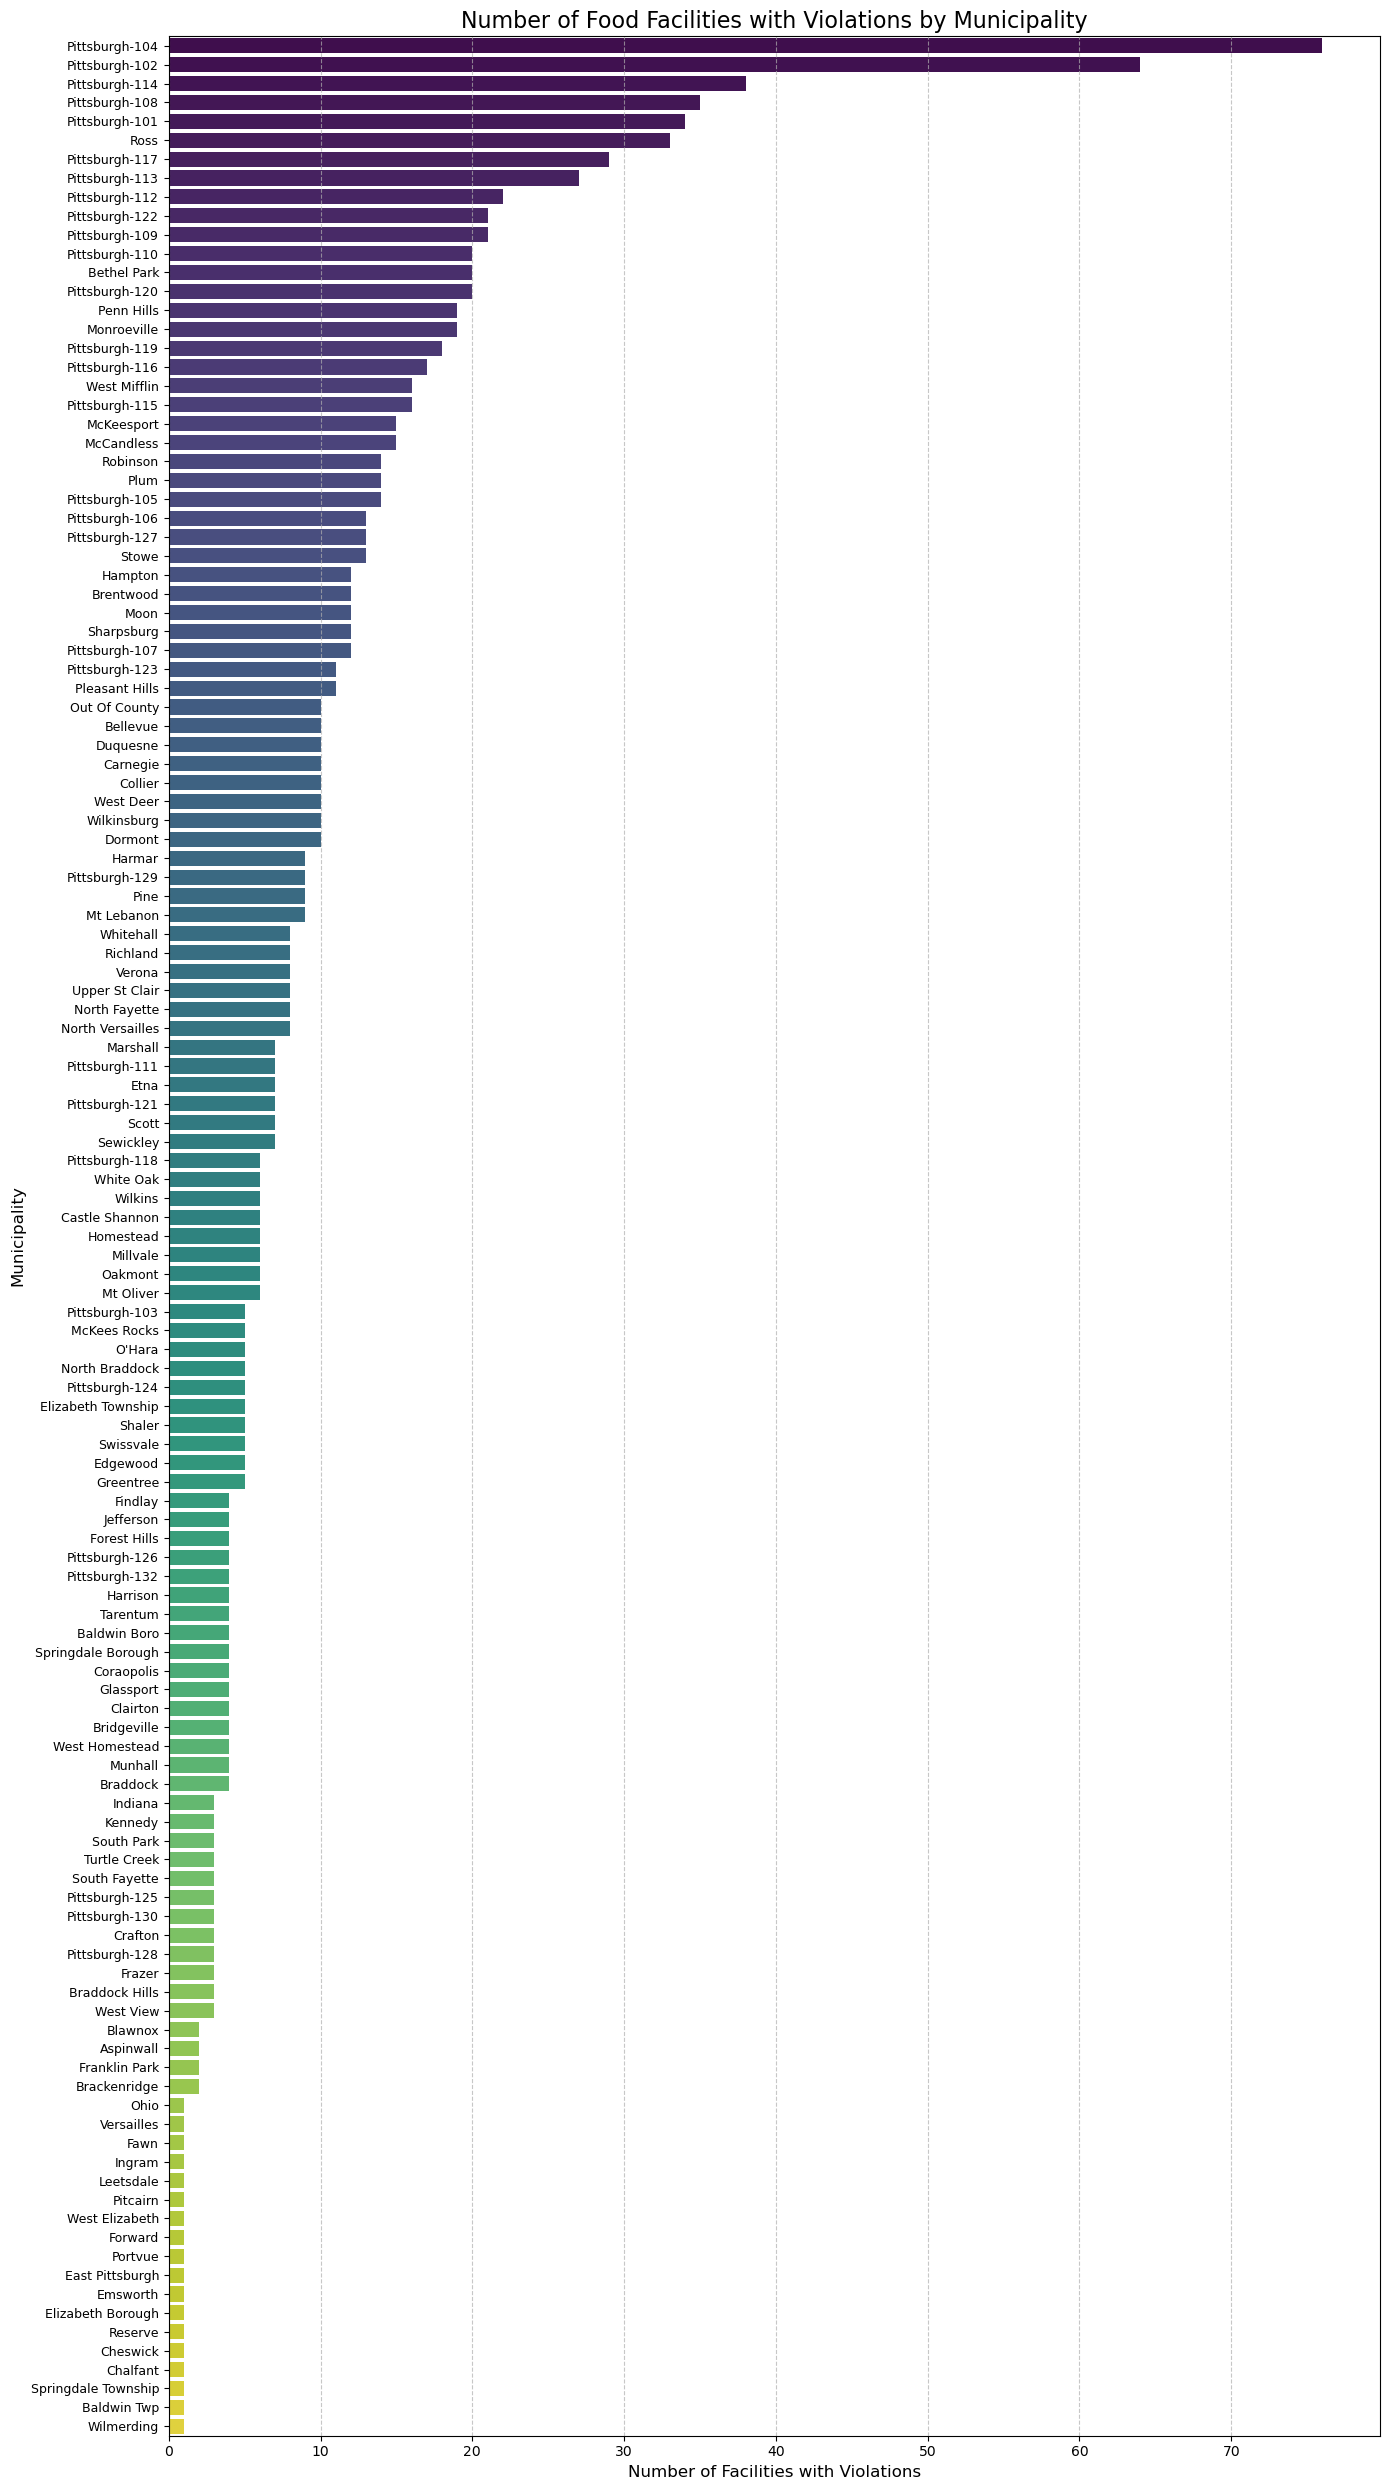

In [19]:
plt.figure(figsize=(14, 25))
sns.barplot(data=violation_counts, y='municipal', x='ViolationFacilityCount', palette='viridis')
plt.title("Number of Food Facilities with Violations by Municipality", fontsize=16)
plt.xlabel("Number of Facilities with Violations", fontsize=12)
plt.ylabel("Municipality", fontsize=12)
plt.yticks(fontsize=9)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('food.png')
plt.show()

In [20]:
all_municipalities = set(df_clean['municipal'].unique())
violation_municipalities = set(df_violations['municipal'].unique())

no_violation_municipalities = sorted(all_municipalities - violation_municipalities)

In [21]:
neighborhoods = sorted(df_clean['placard_desc'].unique())

**Police Arrest Data - Hanzhang Bao**

In [22]:
df = pd.read_csv('Pittsburgh Police Arrest Data.csv')

In [23]:
df_clean = df.dropna(subset=['OFFENSES', 'INCIDENTNEIGHBORHOOD', 'ARRESTTIME'])
df_clean['ARRESTTIME'] = pd.to_datetime(df_clean['ARRESTTIME'], errors='coerce')

df_reduced = df_clean[['OFFENSES', 'INCIDENTNEIGHBORHOOD', 'ARRESTTIME']]
df_reduced['ARRESTTIME'] = df_reduced['ARRESTTIME'].dt.year

/scratch/slurm-13557/ipykernel_172951/697646174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ARRESTTIME'] = pd.to_datetime(df_clean['ARRESTTIME'], errors='coerce')
/scratch/slurm-13557/ipykernel_172951/697646174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['ARRESTTIME'] = df_reduced['ARRESTTIME'].dt.year


In [24]:
neighborhood_counts = df_reduced.groupby('INCIDENTNEIGHBORHOOD').size().reset_index(name='ArrestCount')
neighborhood_counts = neighborhood_counts.sort_values('ArrestCount', ascending=False)

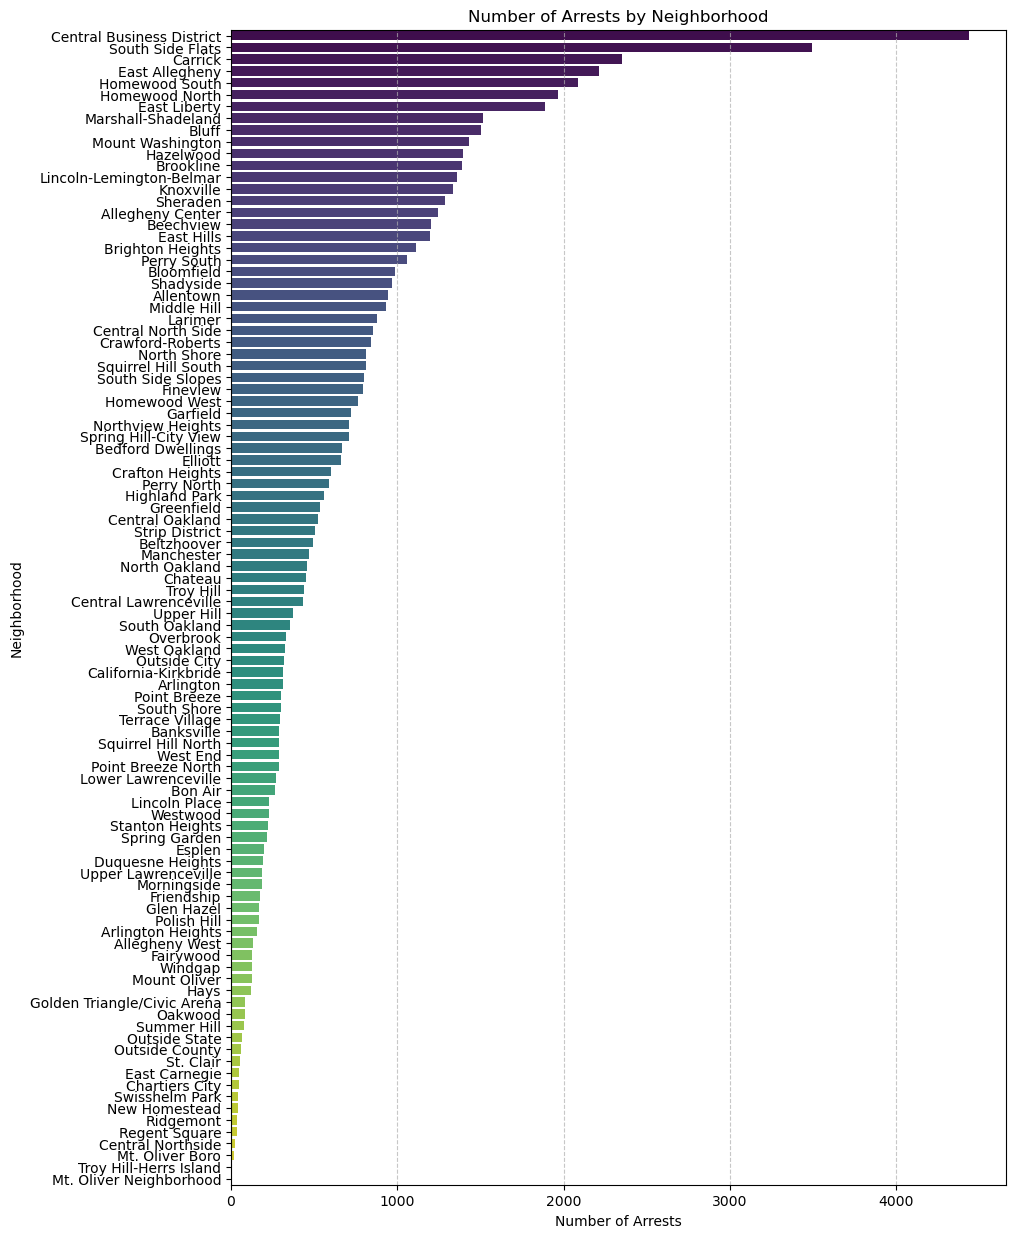

In [25]:
plt.figure(figsize=(10, 15))
sns.barplot(data=neighborhood_counts, y='INCIDENTNEIGHBORHOOD', x='ArrestCount', palette='viridis')
plt.title("Number of Arrests by Neighborhood")
plt.xlabel("Number of Arrests")
plt.ylabel("Neighborhood")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('arrest.png')
plt.show()

In [26]:
years_to_remove = [1998, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
df_reduced = df_reduced[~df_reduced['ARRESTTIME'].isin(years_to_remove)]
yearly_counts = df_reduced.groupby('ARRESTTIME').size().reset_index(name='ArrestCount')

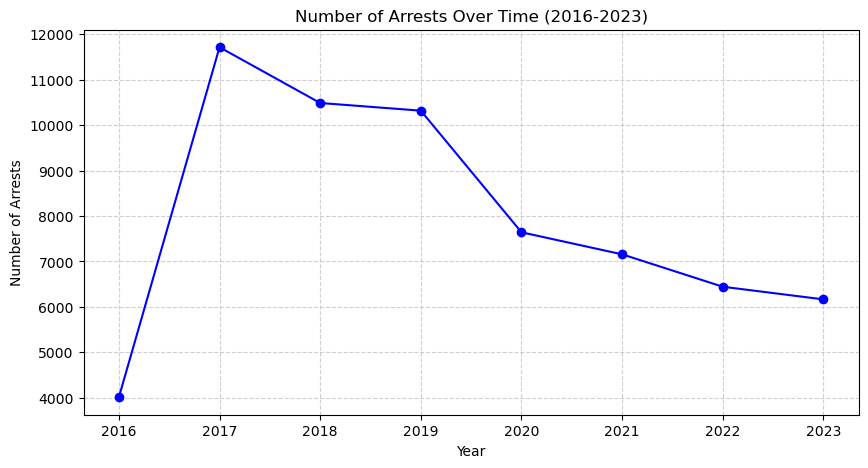

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(yearly_counts['ARRESTTIME'], yearly_counts['ArrestCount'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests Over Time (2016-2023)')
plt.xticks(yearly_counts['ARRESTTIME'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [28]:
selected_hoods = ["New Homestead", "Glen Hazel", "Hays", "Oakwood", "Fairywood", "Westwood", "Swisshelm Park", "Summer Hill", "East Carnegie", "St. Clair"]
df_selected = df_reduced[df_reduced['INCIDENTNEIGHBORHOOD'].isin(selected_hoods)]
pivot = df_selected.groupby(['ARRESTTIME', 'INCIDENTNEIGHBORHOOD']).size().unstack()

<Figure size 1200x800 with 0 Axes>

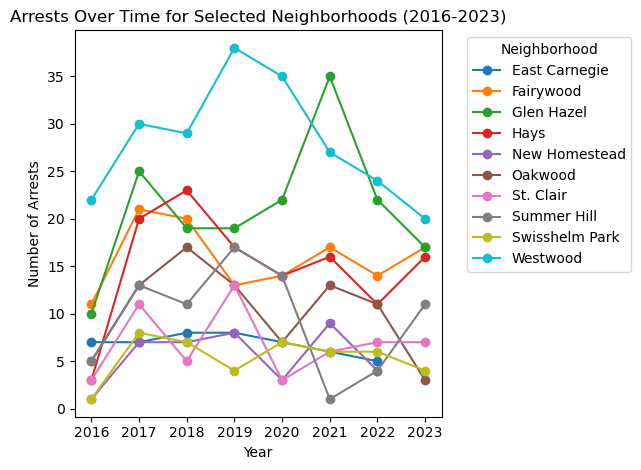

In [29]:
plt.figure(figsize=(12,8))
pivot.plot(marker='o')
plt.title('Arrests Over Time for Selected Neighborhoods (2016-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Arrests')
plt.xticks(pivot.index)
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [30]:
df_selected = df_reduced[df_reduced['INCIDENTNEIGHBORHOOD'].isin(selected_hoods)]
offense_counts_selected = df_selected.groupby(['INCIDENTNEIGHBORHOOD', 'OFFENSES']).size().reset_index(name='Count')

idx = offense_counts_selected.groupby('INCIDENTNEIGHBORHOOD')['Count'].idxmax()
top_offense_per_selected = offense_counts_selected.loc[idx].reset_index(drop=True)

print(top_offense_per_selected)

  INCIDENTNEIGHBORHOOD                                           OFFENSES  \
0        East Carnegie                               2701 Simple Assault.   
1            Fairywood                               2701 Simple Assault.   
2           Glen Hazel                               2701 Simple Assault.   
3                 Hays                               2701 Simple Assault.   
4        New Homestead                               2701 Simple Assault.   
5              Oakwood                               2701 Simple Assault.   
6            St. Clair                               2701 Simple Assault.   
7          Summer Hill                               2701 Simple Assault.   
8       Swisshelm Park  2701(a)(1) Simple Assault - Intent., Know., Re...   
9             Westwood                               2701 Simple Assault.   

   Count  
0      6  
1     19  
2     20  
3     10  
4      4  
5      8  
6      6  
7      5  
8      4  
9     21  


**Metric**<br>
Our metric was how safe a neighborhood is. We felt that safety is one of the most important things for a neighborhood to have and that many of the other metrics would not matter quite as much. If we wanted to visit a neighborhood, or even live in it, the number one concern would be how safe it is. Also, safety attracts businesses and other things that make the neighborhood better.


**Best Neighborhood**<br>
We decided that the best neighborhood was Hays.

**Conclusion - Jason Wein**<br>
Personally, the only neighborhood I know well in Pittsburgh are those in the Oakland area which have a moderate amount of safety due to being university areas. It seems like Hays is more of a woodland area in Pittsburgh with a lower population, so it is much different than Oakland. It also explains why it scored so well in safety as there are not as many building fires, crimes, or food problems. It does seem like a relatively nice place to visit or live in, which makes it, in my opinion, a good neighborhood. My own home neighborhood is more of a suburbs while Hays seems more rural, so there is a difference there. On the other hand, they both are very safe (as shown by our analysis for Hays and by my experience for my hometown).